# Vehicle Tracking

## Feature Selection

In [1]:
# Develop training - test dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import glob


project_path = "/home/james/Documents/CarND-VehicleDetection-P5/"

# Import Images:
vehicles_folder = glob.glob(project_path + "Dataset/vehicles/*")
non_vehicles_folder = glob.glob(project_path + "Dataset/non-vehicles/*")

Vehicles = []
NotVehicles = []

# Read all vehicles
for subfolder in vehicles_folder:
    images = glob.glob(subfolder + "/*.png")
    for image in images:
        Vehicles.append(cv2.imread(image)) # Read Image as BGR, 0 - 255.
        
# Read all non-vehicles
for subfolder in non_vehicles_folder:
    images = glob.glob(subfolder + "/*.png")
    for image in images:
        img = cv2.imread(image)# Read Image as BGR, 0 - 255.
        NotVehicles.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB) ) #  Save images as RGB

vehsize = len(Vehicles)
notvehsize = len(NotVehicles)
total = vehsize + notvehsize
print(str(len(Vehicles)) + " Vehicles Images Imported. "+ str(round(100*vehsize/(total),2)) + "%")
print(str(len(NotVehicles)) + " Non Vehicle Images Imported. "+ str(round(100*notvehsize/(total),2)) + "%")


# Define Helper Function to Convert Images, input must be RGB
def ConvertColorSpace(img,cspace):
    if cspace != 'RGB':

        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else:
        feature_image = np.copy(img) 
    return feature_image

8792 Vehicles Images Imported. 49.5%
8968 Non Vehicle Images Imported. 50.5%


### Color histogram

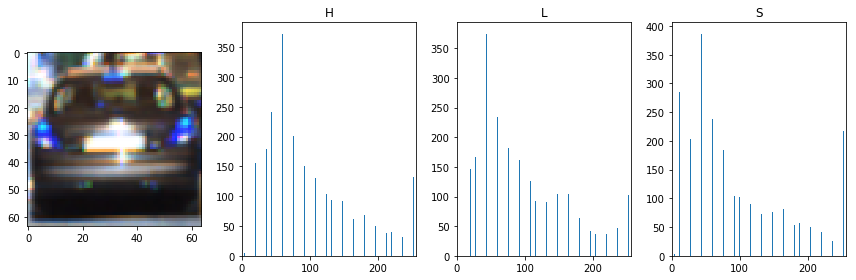

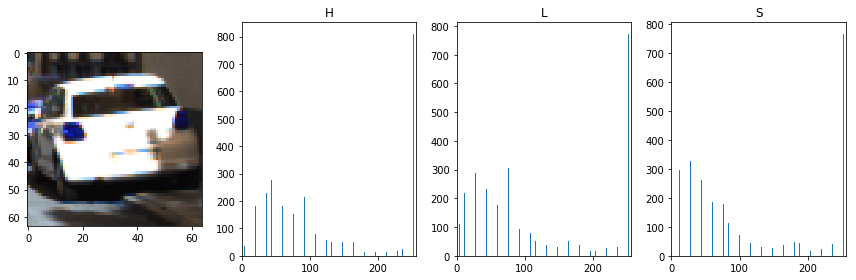

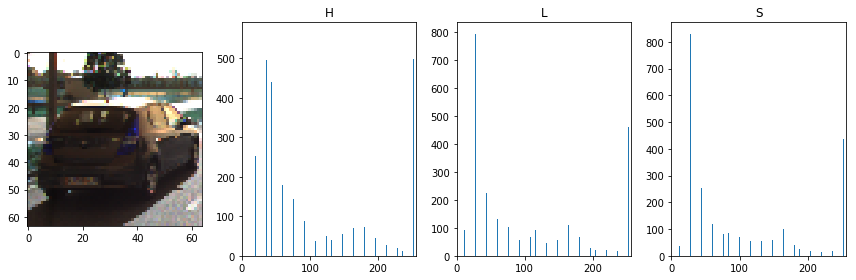

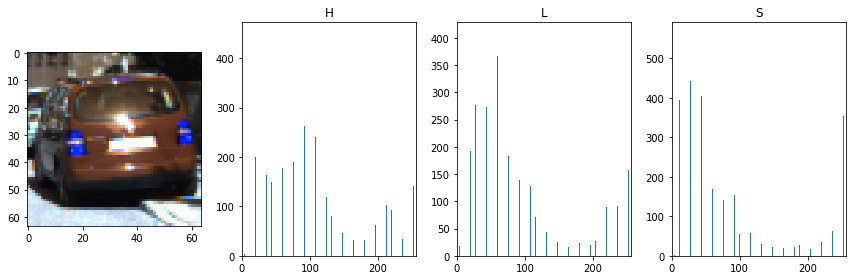

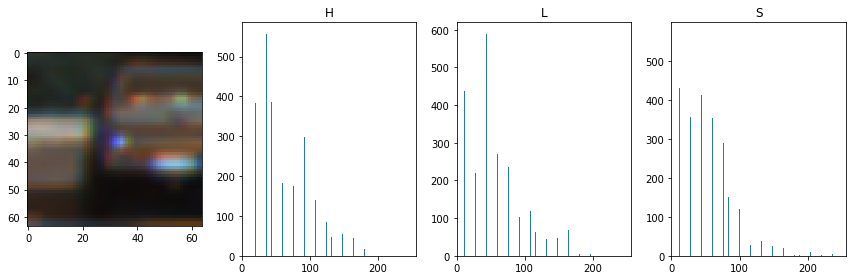

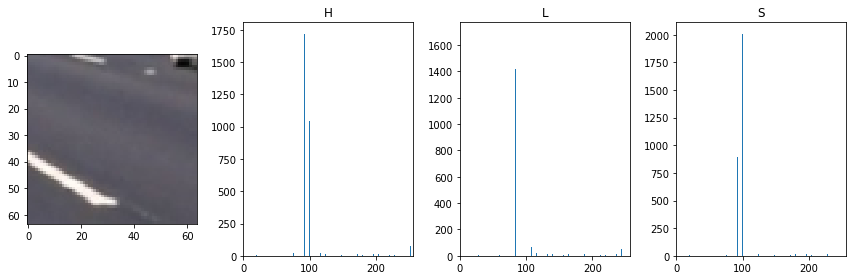

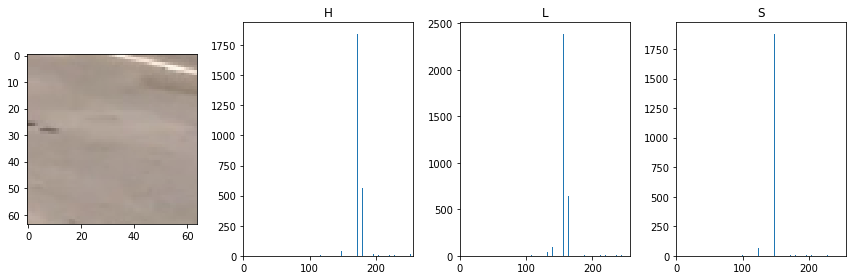

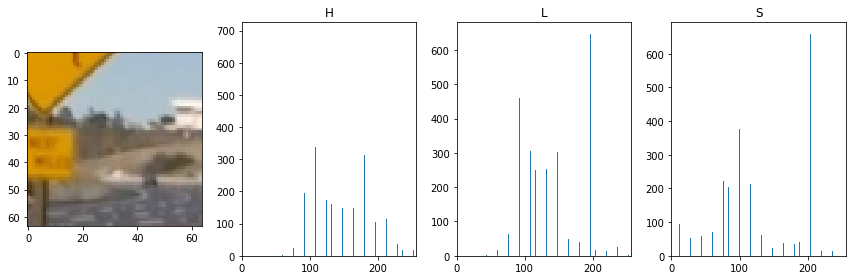

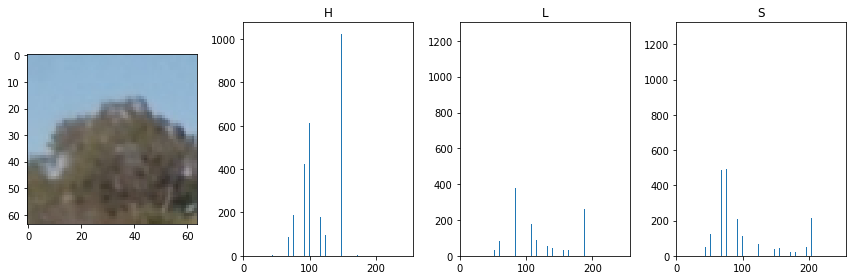

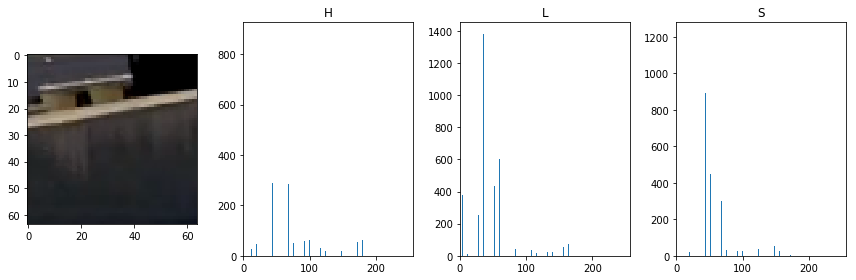

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins, bins_range):
    # Compute the histogram of the channels (1, 2, & 3) separately
    hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist1, hist2, hist3, bin_centers, hist_features

def display_hist(img_list,cspace): 
    for image in img_list:
        feature_image =  ConvertColorSpace(image,cspace)
        c1, c2, c3, bincen, feature_vec = color_hist(feature_image, nbins=32, bins_range=(0, 256))
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1,4,1)
        plt.imshow(image)    
        plt.subplot(1,4,2)
        plt.bar(bincen, c1[0])
        plt.xlim(0, 256)
        plt.title('H')
        plt.subplot(1,4,3)
        plt.bar(bincen, c2[0])
        plt.xlim(0, 256)
        plt.title('L')
        plt.subplot(1,4,4)
        plt.bar(bincen, c3[0])
        plt.xlim(0, 256)
        plt.title('S')
        fig.tight_layout()
        
# Test color_hist:

# get random n vehicle images
n=5
x = np.random.randint(0, vehsize-n)
images_vehicle= Vehicles [x: x+n]
images_nonvehicle = NotVehicles[x: x+n]

display_hist(images_vehicle,'RGB')
display_hist(images_nonvehicle,'RGB')

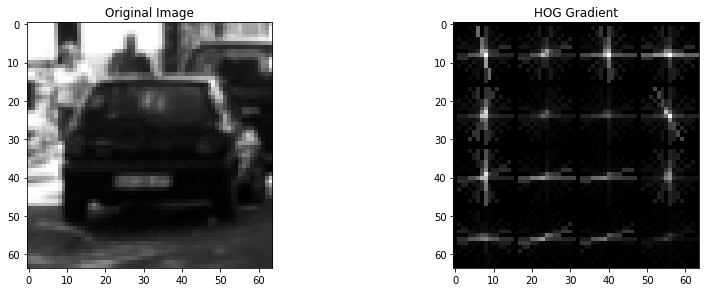

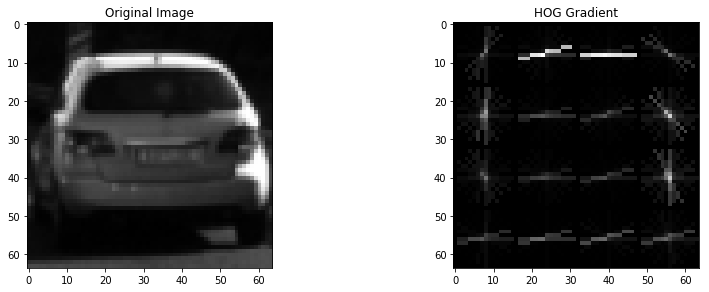

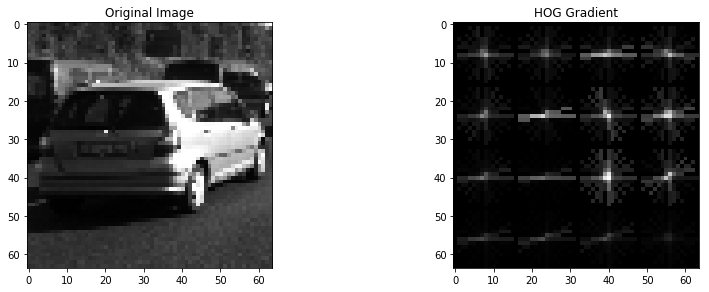

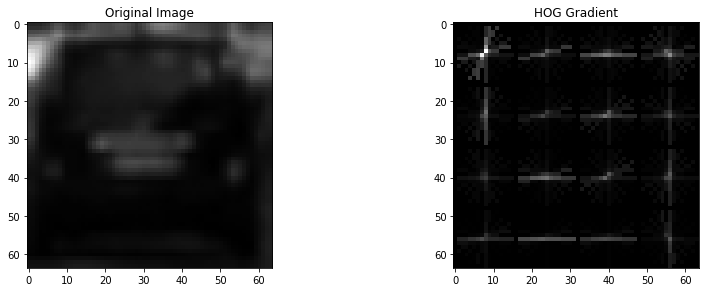

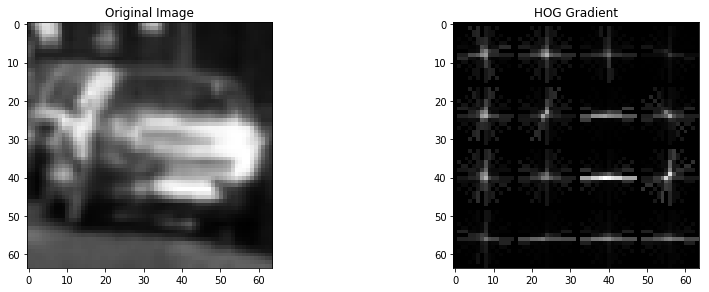

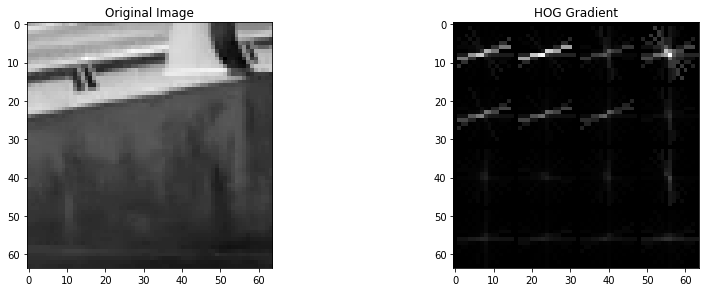

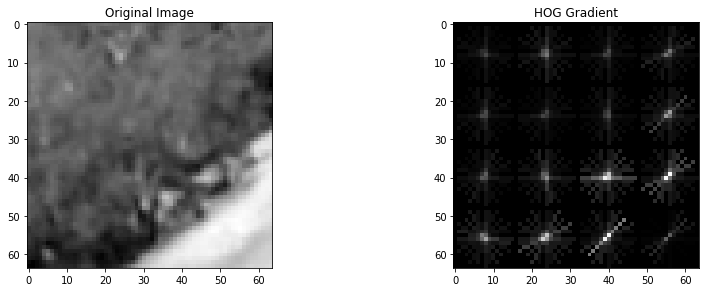

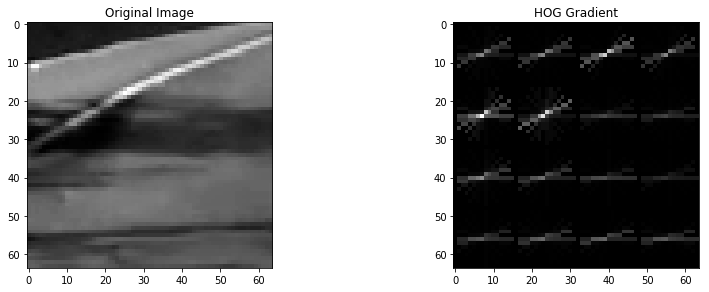

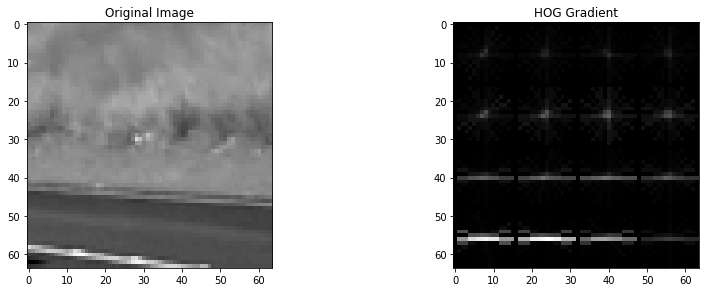

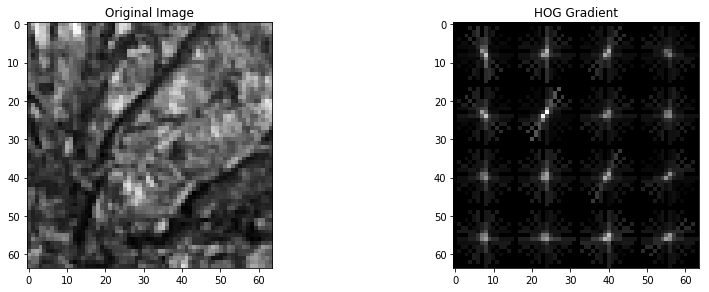

In [3]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis, feature_vec):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)        
        return features
    
# Developing HOG Feature Extraction:

#HOG Parameters for development:
cspace_HOG_d = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient_d  = 12
pix_per_cell_d  = 16
cell_per_block_d  = 2
hog_channel_d  = 0 

# Get random n vehicle images
n=5
x = np.random.randint(0, vehsize-n)
images_car= Vehicles [x: x+ n]
images_nocar = NotVehicles[x: x+n]
images_list = images_car + images_nocar

# Run HOG and compare outputs:
for img in images_list:
    feature_image =  ConvertColorSpace(img,cspace_HOG_d)   
    
    
    
    f_vec, image_hog = get_hog_features(feature_image[:,:,hog_channel_d], orient_d,
                                        pix_per_cell_d, cell_per_block_d,True,True)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    ax1.imshow(feature_image[:,:,0],cmap = 'gray')
    ax1.set_title('Original Image' )
    ax2.imshow(image_hog,cmap = 'gray')
    ax2.set_title('HOG Gradient')

In [4]:
# Define a function to compute binned color features  
# Input img must be RGB. If grayscale, specifiy gray input to True.
def bin_spatial(img, size, gray):
    if(gray):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        return cv2.resize(img, size).ravel() 
    else:
        return cv2.resize(img, size).ravel() 

In [5]:
#Define a function that extracts the following three features from a list of images:
# 1) Color Histogram in RGB
# 2) Spatial Binning
# 3) HOG Feature Extraction

def extract_features(imgs, cspace_hist, cspace_HOG, spatial_size,hist_bins, hist_range,orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    # Create lists to append feature vectors 
    spatial_features = []
    hist_features = []
    hog_features = np.array([])
    features = []
    for image in imgs:
        # Convert image to given color space for Histogram & HOG
        img_converted_hist = ConvertColorSpace(image,cspace_hist)        
        img_converted_HOG = ConvertColorSpace(image,cspace_HOG) 
        
        # Color Pixel Histogram Feature Vector:
        c1, c2, c3, bincen, hist_features = color_hist(img_converted_hist, hist_bins, hist_range)
        
        # Spatial Binning Feature Vector:
        spatial_features = bin_spatial(img_converted_hist,spatial_size,False)
        
        # HOG Feature Vector:       

        if hog_channel == 'ALL':
            hog_temp = []
            for channel in range(img_converted_HOG.shape[2]):
                hog_temp = get_hog_features(img_converted_HOG[:,:,channel],orient, 
                                                     pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True)

                hog_temp = np.ravel(hog_temp)
                hog_features = np.concatenate((hog_features,hog_temp))
        else:
            hog_features = get_hog_features(img_converted_HOG[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)     
        hog_features = np.array([]) 
        #print("spatial = ", spatial_features.shape,
        #      "Hist = ",hist_features.shape,
        #      "HOG  =",hog_features.shape)
        #print(img_converted_HOG.shape)
        
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    return features

## Classification

In [6]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import time

# Extract features from vehicle images:
print ("Generating feature vectors...")
print()

t=time.time()

#Color Histogram Parameters:
histbin = 64 # Number of Histogram Bins for Color Histogram Feature Vector (3 x 32 = 96 elements)

# Spatial Binning Parameters:
spatial = 12 # Resize Dimension for spatial binning
cspace_hist = 'RGB' # Color Space for histogram 

#HOG Parameters:
cspace_HOG = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'# Can be 0, 1, 2, or "ALL"

car_features = extract_features(Vehicles, cspace_hist, cspace_HOG, (spatial, spatial), histbin, (0, 256),
                               orient, pix_per_cell, cell_per_block, hog_channel)
notcar_features = extract_features(NotVehicles, cspace_hist, cspace_HOG, (spatial, spatial), histbin, (0, 256),
                               orient, pix_per_cell, cell_per_block, hog_channel)
t2 = time.time()


print('Using HOG parmaters:\n',cspace_HOG,'Color Space\n', hog_channel, 'HOG Channel\n',
      orient, ' orientation bins\n',pix_per_cell,
     'pixels per cell\n', cell_per_block,' cells per block')
print()

X = np.vstack((car_features, notcar_features)).astype(np.float64) # Array stack of feature vectors
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define labels vector
print ("Done!", round(t2-t, 5), 'Seconds to generate features')
print('Feature Vector Size = ' , X.shape)
print('Label Vector Size = ', y.shape)

# Split up data into randomized training(80%)and test(20%) sets
rand_state = np.random.randint(0, 100)
X,y = shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


# Initialize classifier
print("\nTraining classifier...")
svc = svm.LinearSVC()
# Compute the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(100*svc.score(X_test, y_test), 2),"%")
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('\nMy SVC predicts:\t', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels:\t', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Generating feature vectors...

Using HOG parmaters:
 YUV Color Space
 ALL HOG Channel
 12  orientation bins
 16 pixels per cell
 2  cells per block

Done! 64.84884 Seconds to generate features
Feature Vector Size =  (17760, 624)
Label Vector Size =  (17760,)

Training classifier...
4.72 Seconds to train SVC...
Test Accuracy of SVC =  97.16 %

My SVC predicts:	 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
For these 10 labels:	 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
0.00108 Seconds to predict 10 labels with SVC


## Vehicle Tracking

### Develop Tracking Boxes

In [7]:
# Function that draws boxes boxes on img with color and thickness
def draw_boxes(img, bboxes, color, thick):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    

In [8]:
import math

#Generate 4 layers of box sizes to be used in sliding window approach
# Layer 1 = Largest box size concentrated at bottom of image
# Layer 4 = smallest boxes found in the distance
def slide_window(img, x_start_stop, y_start_stop):
    boxes = []
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    
    img_height = img.shape[0]
    img_width = img.shape[1]    
    
    #Layer 1:
    for i in range(0,7):
        boxes.append(((np.int(i*320/2.0),ystart),(np.int(320*(i*1/2.0 + 1)),ystop)))    
   
    #Layer 2:
    
    # Compute the span of the region to be searched    
    xy_window = (160,180)
    xy_overlap = (0.5,0.5)
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            boxes.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    
    #Layer 3:
    
    
    #Layer 4:
    
    return boxes


False

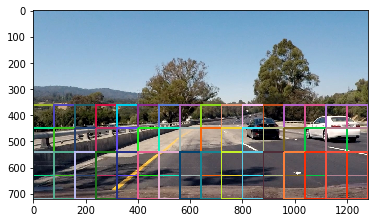

In [10]:
# Restrict serach boundary to bottom half of image where vehicles are most likely

image_window = cv2.imread(project_path + "test_images/" + "test4.jpg")
image_window = cv2.cvtColor(image_window,cv2.COLOR_BGR2RGB)

img_height = image_window.shape[0]
img_width = image_window.shape[1]

windows = slide_window(image_window, [0, img_width ], [int(img_height*0.5),
                    img_height])

window_img = draw_boxes(image_window, windows,(0, 0, 255), 6)

plt.imshow(window_img)
cv2.imwrite("ReportImagesXXX/Layer2_Boxes.png",cv2.cvtColor(window_img,cv2.COLOR_RGB2BGR))

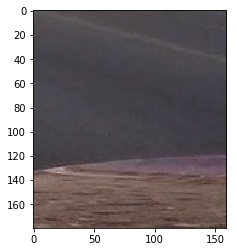

In [20]:
#This function takes an image and returns the same image with superimposed boxes over identified vehicles
#Input image must be in RGB format
def car_search(image,svc,search_windows):
    
    #Color Histogram Parameters:
    histbin = 64 # Number of Histogram Bins for Color Histogram Feature Vector (3 x 32 = 96 elements)

    # Spatial Binning Parameters:
    spatial = 12 # Resize Dimension for spatial binning
    cspace_hist = 'RGB' # Color Space for histogram 

    #HOG Parameters:
    cspace_HOG = 'YUV' #can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"    
    
    found_boxes = [] #list to store boxes where vehicles are found      
    
    for box in search_windows:
        #Extract rectangular box from image to search
        extract_img = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        plt.imshow(extract_img)
        resized_img = [cv2.resize(extract_img,(64, 64))] #Resize image as list with numpy array
        
        #Use Trained model to predict whether a vehicle present in box
        car_features = extract_features(resized_img, cspace_hist, cspace_HOG, (spatial, spatial),
                                        histbin, (0, 256),orient, pix_per_cell, cell_per_block, hog_channel)
        Scaled_Features = X_scaler.transform(car_features)
        predict = svc.predict(Scaled_Features)
        if( predict == 1 ):
            found_boxes.append(box)
            
            
    vehicles_img = draw_boxes(image, found_boxes,(0, 0, 255), 3)

    return vehicles_img
    
    
image_test = cv2.imread(project_path + "test_images/" + "test6.jpg")
image_test= cv2.cvtColor(image_test,cv2.COLOR_BGR2RGB)    


return_img = car_search(image_test,svc,windows)

#plt.imshow(return_img)
    
    